In [1]:
import numpy as np
import pandas as pd

from astropy import coordinates
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
import astroquery
from astroquery.irsa import Irsa
from astroquery.vizier import Vizier
from astropy.table import Table, join

Irsa.ROW_LIMIT = -1
Vizier.ROW_LIMIT = -1

import matplotlib.pyplot as plt

%matplotlib inline

# Get the data

2MASS => J, H K, angular resolution ~4"

WISE => 3.4, 4.6, 12, and 22 μm (W1, W2, W3, W4) with an angular resolution of 6.1", 6.4", 6.5", & 12.0" 

GALEX imaging => Five imaging surveys in a Far UV band (1350-1750Å) and Near UV band (1750-2800Å) with 6-8 arcsecond resolution (80% encircled energy) and 1 arcsecond astrometry, and a cosmic UV background map.

In [2]:
#obj = ["3C 454.3", 343.49062, 16.14821, 1.0]
obj = ["PKS J0006-0623", 1.55789, -6.39315, 1.0]
#obj = ["M87", 187.705930, 12.391123, 1.0]
#### name, ra, dec, radius of cone

obj_name = obj[0]
obj_ra   = obj[1]
obj_dec  = obj[2]
cone_radius  = obj[3]

In [3]:
obj_coord = coordinates.SkyCoord(ra=obj_ra, dec=obj_dec, unit=(u.deg, u.deg), frame="icrs")

In [4]:
# Query data
data_2mass = Irsa.query_region(obj_coord, catalog="fp_psc", radius=cone_radius * u.deg)
data_wise  = Irsa.query_region(obj_coord, catalog="allwise_p3as_psd", radius=cone_radius * u.deg)
__data_galex = Vizier.query_region(obj_coord, catalog='II/335', radius=cone_radius * u.deg)
data_galex = __data_galex[0]

In [5]:
num_2mass = len(data_2mass)
num_wise  = len(data_wise)
num_galex = len(data_galex)

print("Number of object in (2MASS, WISE, GALEX): ", num_2mass, num_wise, num_galex)

Number of object in (2MASS, WISE, GALEX):  4802 38322 10105


# Matching coordinates

In [6]:
# use only coordinate columns
ra_2mass = data_2mass['ra']
dec_2mass = data_2mass['dec']
c_2mass = coordinates.SkyCoord(ra=ra_2mass, dec=dec_2mass, unit=(u.deg, u.deg), frame="icrs")

ra_wise  = data_wise['ra']
dec_wise = data_wise['dec']
c_wise = coordinates.SkyCoord(ra=ra_wise, dec=dec_wise, unit=(u.deg, u.deg), frame="icrs")

ra_galex  = data_galex['RAJ2000']
dec_galex = data_galex['DEJ2000']
c_galex = coordinates.SkyCoord(ra=ra_galex, dec=dec_galex, unit=(u.deg, u.deg), frame="icrs")

In [7]:
####
sep_min = 1.0 * u.arcsec # minimum separation in arcsec

In [8]:
# Only 2MASS and WISE matching 
#
idx_2mass, idx_wise, d2d, d3d = c_wise.search_around_sky(c_2mass, sep_min)
# select only one nearest if there are more in the search reagion (minimum seperation parameter)!

print("Only 2MASS and WISE: ", len(idx_2mass))

Only 2MASS and WISE:  4292


### Plot $W_1-J$ vs $W_1$

In [9]:
# from matching of 2 cats (2MASS and WISE) coordinate
data_2mass_matchwith_wise = data_2mass[idx_2mass]
data_wise_matchwith_2mass = data_wise[idx_wise] # WISE dataset

w1 = data_wise_matchwith_2mass['w1mpro']
j = data_2mass_matchwith_wise['j_m']
w1j = w1-j

cutw1j = -1.7 # https://academic.oup.com/mnras/article/448/2/1305/1055284

# WISE galaxy data -> from cut
galaxy = data_wise_matchwith_2mass[w1j < cutw1j] 
print("Number of galaxy from cut W1-J:", len(galaxy))

Number of galaxy from cut W1-J: 455


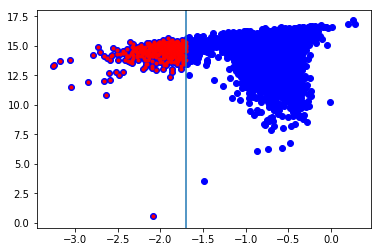

In [10]:
w1j_galaxy = w1j[w1j<cutw1j]
w1_galaxy = w1[w1j<cutw1j]

plt.scatter(w1j, w1, marker='o', color='blue')
plt.scatter(w1j_galaxy, w1_galaxy, marker='.', color="red")
          
plt.axvline(x=cutw1j) # https://academic.oup.com/mnras/article/448/2/1305/1055284

- W1-J < -1.7 => galaxy
- W1-J > -1.7 => stars

# Filter all Cats

In [11]:
# GALEX
###
# coord of object in 2mass which match wise (first objet/nearest in sep_min region)
c_2mass_matchwith_wise = c_2mass[idx_2mass]
c_wise_matchwith_2mass = c_wise[idx_wise]

#Check with 2mass cut
idx_2mass_wise_galex, idx_galex1, d2d, d3d = c_galex.search_around_sky(c_2mass_matchwith_wise, sep_min)
num_galex1 = len(idx_galex1)
#Check with wise cut
idx_wise_2mass_galex, idx_galex2, d2d, d3d = c_galex.search_around_sky(c_wise_matchwith_2mass, sep_min)
num_galex2 = len(idx_galex2)

print("Number of GALEX match in 2MASS cut (with WISE): ", num_galex1)
print("Number of GALEX match in WISE cut (with 2MASS): ", num_galex2)

# diff/average
print("Confusion level: ", abs(num_galex1 - num_galex2)/np.mean([num_galex1, num_galex2])*100, "%")

Number of GALEX match in 2MASS cut (with WISE):  805
Number of GALEX match in WISE cut (with 2MASS):  814
Confusion level:  1.1117974058060531 %


In [12]:
# Choose which one is smaller!
if num_galex1 < num_galex2:
    select_from_galex = idx_galex1
    
    match_galex = data_galex[select_from_galex]
    c_selected_galex = c_galex[select_from_galex]
    
    # 2MASS from GALEX_selected
    _idx_galex1, _idx_2mass, d2d, d3d = c_2mass.search_around_sky(c_selected_galex, sep_min)
    match_2mass = data_2mass[_idx_2mass]
    
    # WISE from 2MASS_selected
    _ra_match_2mass = match_2mass['ra']
    _dec_match_2mass = match_2mass['dec']
    _c_match_2mass = coordinates.SkyCoord(ra=_ra_match_2mass, dec=_dec_match_2mass, unit=(u.deg, u.deg), frame="icrs")

    _idx, _idx_wise, d2d, d3d = c_wise.search_around_sky(_c_match_2mass, sep_min)
    match_wise = data_wise[_idx_wise]
    
else:
    select_from_galex = idx_galex2

    match_galex = data_galex[select_from_galex]
    c_selected_galex = c_galex[select_from_galex]
    
    # WISE from GALEX_selected
    _idx_galex1, _idx_wise, d2d, d3d = c_wise.search_around_sky(c_selected_galex, sep_min)
    match_wise = data_wise[_idx_wise]
    
    # 2MASS from WISE_selected
    _ra_match_wise = match_wise['ra']
    _dec_match_wise = match_wise['dec']
    _c_match_wise = coordinates.SkyCoord(ra=_ra_match_wise, dec=_dec_match_wise, unit=(u.deg, u.deg), frame="icrs")

    _idx, _idx_2mass, d2d, d3d = c_2mass.search_around_sky(_c_match_wise, sep_min)
    match_2mass = data_2mass[_idx_2mass]

print("Number of match in GALEX: ", len(match_galex))
print("Number of match in 2MASS: ", len(match_2mass))
print("Number of match in WISE : ", len(match_wise))

Number of match in GALEX:  805
Number of match in 2MASS:  805
Number of match in WISE :  805


# Collect relevant data

In [13]:
joindata = np.array([match_2mass['j_m']-match_2mass['h_m'], 
                  match_2mass['j_m']-match_2mass['k_m'],
                  match_2mass['j_m']-match_wise['w1mpro'], 
                  match_2mass['j_m']-match_wise['w2mpro'],
                  match_2mass['j_m']-match_wise['w3mpro'],
                  match_2mass['j_m']-match_wise['w4mpro'],
                  match_2mass['j_m']-match_galex['NUVmag']])

joindata = joindata.T

# Analysis 
we can try: 
- dimensionality reduction
- clustering 
- classification
- data embedding

### PCA

In [14]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = scale(joindata)

pca = PCA(n_components=4)
X_r = pca.fit(X).transform(X)

print(pca.components_)
print(pca.explained_variance_)

[[ 0.36259022  0.41802673  0.42528611  0.42595846  0.40764721  0.34387904
   0.21689641]
 [ 0.40195562  0.20576211  0.2308608   0.20453541 -0.3065228  -0.44695684
  -0.63815009]
 [-0.20284831  0.02282078  0.27005901  0.31724886 -0.32330789 -0.54692768
   0.61732907]
 [ 0.80967267 -0.17848348 -0.25540376 -0.27259548 -0.12589313 -0.07904049
   0.38850736]]
[4.7185145  1.37718596 0.48570517 0.20892348]


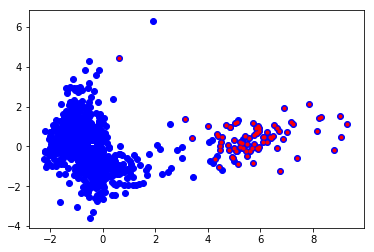

In [15]:
# plot PCA result
# Plot data using PC1 vs PC2
plt.scatter(X_r[:,0], X_r[:,1], marker='o', color='blue')

# overplot galaxy selected using cut W1-J
for i, name in enumerate(match_wise['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.scatter(X_r[i,0], X_r[i,1], marker=".", color="red")

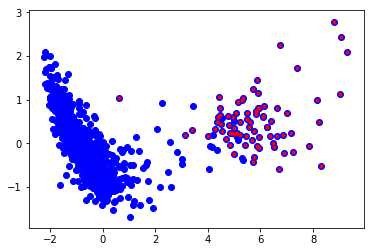

In [16]:
# plot PCA result
# Plot data using PC1 vs PC2
plt.scatter(X_r[:,0], X_r[:,2], marker='o', color='blue')

# overplot galaxy selected using cut W1-J
for i, name in enumerate(match_wise['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.scatter(X_r[i,0], X_r[i,2], marker=".", color="red")

### DBSCAN

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = scale(joindata)

db = DBSCAN(eps=1, min_samples=3).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
#print(labels)

Estimated number of clusters: 5


#### Plot $W_1 - J$ vs $J$

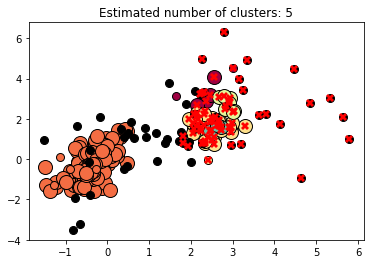

In [18]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    
    ## J vs J-W1
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 3], xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 3], xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=8)
    
for i, name in enumerate(match_wise['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.plot(X[i,3], X[i,0], marker="X", markerfacecolor='red', markeredgecolor='none', markersize=8)  

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### t-SNE

In [19]:
from sklearn.manifold import TSNE
X = scale(joindata)
X_r = TSNE(n_components=2).fit_transform(X)

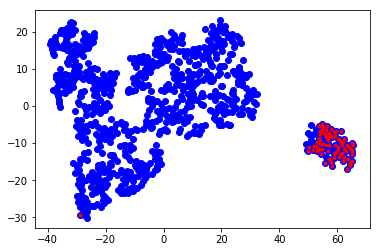

In [20]:
plt.scatter(X_r[:,0], X_r[:,1], marker='o', color="blue")
for i, name in enumerate(match_wise['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.scatter(X_r[i,0], X_r[i,1], marker='.', color="red")  

In [27]:
match_2mass.colnames

['ra',
 'dec',
 'clon',
 'clat',
 'err_maj',
 'err_min',
 'err_ang',
 'designation',
 'j_m',
 'j_cmsig',
 'j_msigcom',
 'j_snr',
 'h_m',
 'h_cmsig',
 'h_msigcom',
 'h_snr',
 'k_m',
 'k_cmsig',
 'k_msigcom',
 'k_snr',
 'ph_qual',
 'rd_flg',
 'bl_flg',
 'cc_flg',
 'ndet',
 'gal_contam',
 'mp_flg',
 'hemis',
 'xdate',
 'scan',
 'glon',
 'glat',
 'a',
 'dist_opt',
 'phi_opt',
 'b_m_opt',
 'vr_m_opt',
 'nopt_mchs',
 'ext_key',
 'dist',
 'angle',
 'j_h',
 'h_k',
 'j_k',
 'id']